In [1]:
#%matplotlib notebook
import time, winsound, h5py
import numpy as np
import matplotlib.pyplot as plt
from lcls_beamline_toolbox.xraybeamline2d import beam1d as beam, optics1d as optics, beamline1d as beamline

### Beam parameters

In [2]:
# number of sampling points
N = 2048
# photon energy in eV
E0 = 17795

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 23e-6,
    'sigma_y': 23e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 630
}

In [3]:
def define_devices(eta_err, slit_width=500e-6, crystal=1,
                   f1 = 9.775183946488294, f2 = 10., alphaAsym=np.deg2rad(27.98), E0 = E0,
                   f0 = 290., d23=7.):
    # crystal reflection hkl index
    hkl = [6,6,0]

    # viewing point upstream of monochromator
    im0 = optics.PPM('im0', z=870, FOV=2e-3, N=256)
    crl0 = optics.CRL('crl0', z=920, E0=E0, f=f0, diameter=2e-3)

    # first crystal: symmetric reflection
    crystal1 = optics.Crystal('c1', hkl=hkl, length=10e-2, width=20e-3, z=930, E0=E0,
                              alphaAsym=0, orientation=0, pol='s', delta=0.e-6)

    # second crystal: asymmetric reflection, orientation flipped relative to crystal1
    crystal2 = optics.Crystal('c2', hkl=hkl, length=10e-2, width=20e-3, z=crystal1.z+.2, E0=E0,alphaAsym=alphaAsym, 
                              orientation=2,pol='s', delta=0e-6)
    # printing crystal incidence and reflection angles for confirmation
    print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
    print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

    im_upstream = optics.PPM('im_upstream', z=crystal2.z + f1 - .1, FOV=2e-3, N=256)

    # CRL with ~1 meter focal length (modeled as single element for now)
    crl1 = optics.CRL('crl1', z=crystal2.z+f1, E0=E0, f=f2, diameter=5e-3)

    # viewing point downstream of first crl
    im1 = optics.PPM('im1', z=crl1.z+.1,N=256,FOV=2e-3)

    # viewing point at focus
    focus = optics.PPM('focus', z=crl1.z+f2, FOV=100e-6, N=256)

    # slit at focus
    slit = optics.Slit('slit', z=crl1.z+f2 + 1e-3, x_width=slit_width, y_width=2e-3)

    # second CRL with ~1 meter focal length, for collimation
    crl2 = optics.CRL('crl2', z=crl1.z+2*f2, E0=E0, f=f2, diameter=5e-3)

    # third crystal, symmetric reflection, same orientation as crystal2
    crystal3 = optics.Crystal('c3', hkl=hkl, length=10e-2, width=10e-3, z=crl2.z+d23, E0=E0,alphaAsym=0, orientation=2,
                             asym_type='emergence',pol='s')

    # fourth crystal, asymmetric reflection, same orientation as crystal1
    crystal4 = optics.Crystal('c4', hkl=hkl, length=10e-2, width=10e-3, z=crl2.z+d23 + (f1-d23)*np.cos(crystal1.beta0*2), E0=E0,alphaAsym=-alphaAsym, 
                              asym_type='emergence', orientation=0,pol='s')

    # viewing point just downstream of monochromator
    im2 = optics.PPM('im2', z=crystal4.z+.1, FOV=2e-3, N=256)
    
    if crystal == 1:
        crystal1 = optics.Crystal('c1', hkl=hkl, length=10e-2, width=20e-3, z=930, E0=E0,
                              alphaAsym=0+eta_err, orientation=0, pol='s', delta=0.e-6)
    if crystal == 2:
        crystal2 = optics.Crystal('c2', hkl=hkl, length=10e-2, width=20e-3, z=crystal1.z+.2, E0=E0,alphaAsym=alphaAsym+eta_err, 
                              orientation=2,pol='s', delta=0e-6)
    
    if crystal == 3:
        crystal3 = optics.Crystal('c3', hkl=hkl, length=10e-2, width=10e-3, z=crl2.z+d23, E0=E0,alphaAsym=0+eta_err, orientation=2,
                             asym_type='emergence',pol='s')
    
    if crystal == 4:
        crystal4 = optics.Crystal('c4', hkl=hkl, length=10e-2, width=10e-3, z=crl2.z+d23 + (f1-d23)*np.cos(crystal1.beta0*2), E0=E0,
                                  alphaAsym=-alphaAsym+eta_err, asym_type='emergence', orientation=0,pol='s')
        
    # list of devices to propagate through
    devices = [crl0,im0,crystal1,crystal2,im_upstream, im1, crl1, focus, slit, crl2, crystal3, crystal4, im2]

    return devices

### Define beamline for loops

In [4]:
%%capture capt
tstart = time.time()
# initialize optical elements
f1 = 9.775183946488294
f2 = 10.

devices = define_devices(0.)

# initialize beamline
mono_beamline = beamline.Beamline(devices)

for oe in devices:
    if oe.name == 'c1':
        print('crystal 1 incidence angle: {:.2f} degrees'.format(oe.alpha*180/np.pi))
        print('crystal 1 exit angle: {:.2f} degrees\n\n\n'.format(oe.beta0*180/np.pi))

# propagate
beam_params['photonEnergy'] = E0
pulse = beam.Pulse(beam_params=beam_params, tau=100, time_window=4000)
pulse.propagate(beamline=mono_beamline, screen_names=['focus','im2'])
tfin = time.time()

alphaAsym_list = np.zeros(4)
for crystal in [1,2,3,4]:
    for device in devices:
        if device.name == 'c{}'.format(crystal):
            alphaAsym_list[int(crystal-1)] = device.alphaAsym

In [5]:
print('each run: {}s, per slice: {}ms'.format(round(tfin-tstart,2), round(1000*(tfin-tstart)/pulse.N,2)))
''' energy slices '''


each run: 7.05s, per slice: 79.2ms


' energy slices '

### Loops

In [6]:
%%capture capt
tstart = time.time()
NN = 300
eta_list = 1e-6*np.linspace(-10, 10, NN)

fig_path = "C:/Users/nanw0/GoogleDrive/SLAC/SLAC-Diling/9. 20 Summer/Hasan Mono Analysis/Matt's_Plots/"
hkl = devices[2].hkl
hkl = int(hkl[0]*100+hkl[1]*10+hkl[2])
fname = 'miscut_tolerance_{}_{}keV'.format(
    hkl, round(beam_params['photonEnergy']/1000.,4))

for crystal in [1,2,3,4]:
    # initialize results holder
    duration = np.zeros(NN)
    tilt = np.zeros(NN)
    bw = np.zeros(NN)
    throughput = np.zeros(NN)
    cent_E = np.zeros(NN)
    slit_width = 100e-6
    # pulse duration and tilt (open slit)
    for i, eta in enumerate(eta_list):
        devices = define_devices(eta, slit_width, crystal)
        mono_beamline = beamline.Beamline(devices)    # initialize beamline
        beam_params['photonEnergy'] = E0    # reset central photon energy

        # initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
        pulse = beam.Pulse(beam_params=beam_params, tau=100, time_window=4000)

        print('Number of spectral components: {:d}'.format(pulse.N))
        pulse.propagate(beamline=mono_beamline, screen_names=['im2'])
        centroid, duration[i] = pulse.pulse_duration('im2')
        tilt[i] = pulse.pulsefront_tilt('im2')
    tfin = time.time()

    slit_width = 7e-6
    # else (closed slit)
    for i, eta in enumerate(eta_list):
        devices = define_devices(eta, slit_width, crystal)
        mono_beamline = beamline.Beamline(devices)    # initialize beamline
        beam_params['photonEnergy'] = E0    # reset central photon energy

        # initialize pulse. tau sets transform-limited pulse duration in fs (FWHM). Time window is in fs.
        pulse = beam.Pulse(beam_params=beam_params, tau=100, time_window=4000)

        print('Number of spectral components: {:d}'.format(pulse.N))
        pulse.propagate(beamline=mono_beamline, screen_names=['im0','im2'])
        bw[i] = pulse.pulse_bandwidth('im2')
        throughput[i] = pulse.throughput('im0','im2')
        cent_E[i] = pulse.central_energy('im2')
    tfin = time.time()

    for i in range(2):
        winsound.Beep(1000,1000)
        time.sleep(1.1)
    
    # save data
    with h5py.File(fig_path+fname+'.h5', 'a') as f:
        grp = f.create_group('crystal{}'.format(crystal))
        grp.create_dataset('miscut_error', data=eta_list)
        grp.create_dataset('duration', data=duration)
        grp.create_dataset('tilt', data=tilt)
        grp.create_dataset('bandwidth', data=bw)
        grp.create_dataset('throughput', data=throughput)
        grp.create_dataset('central_energy', data=cent_E)


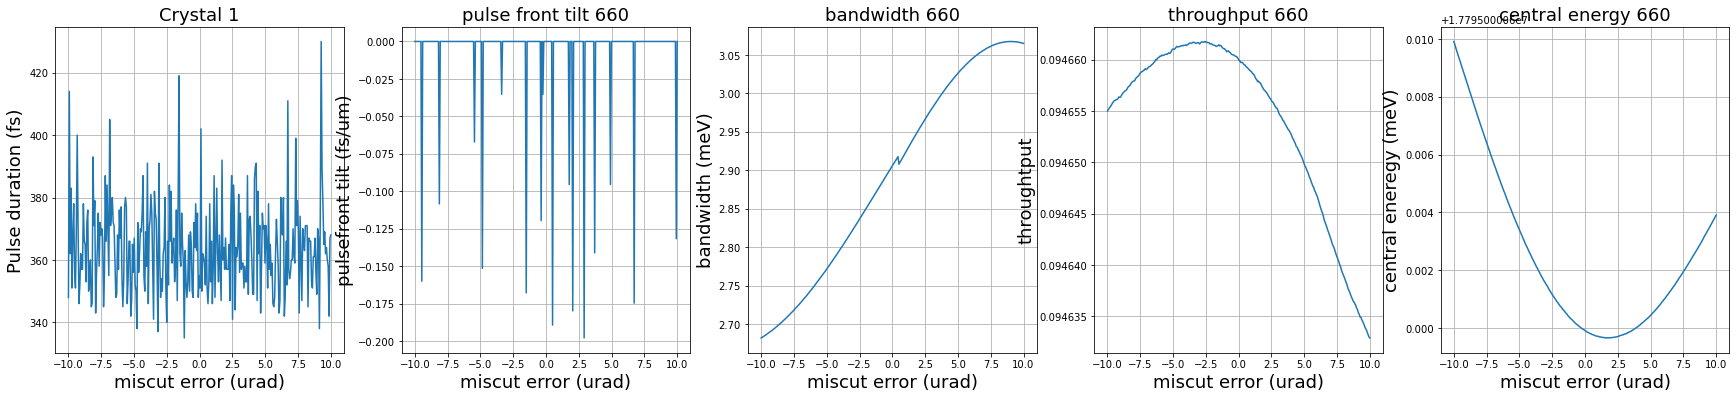

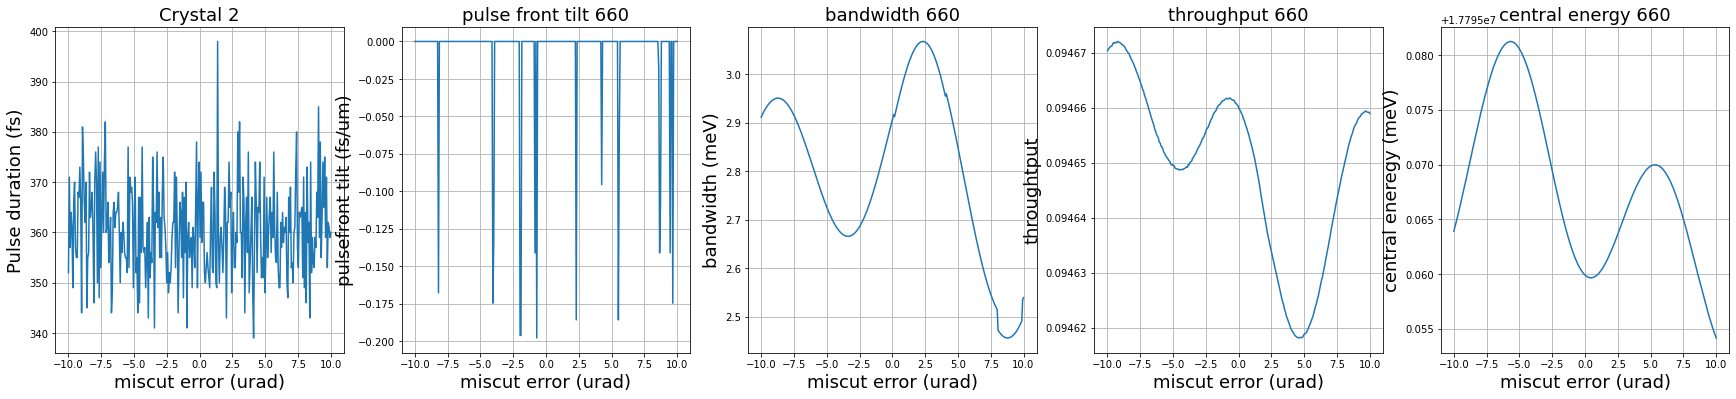

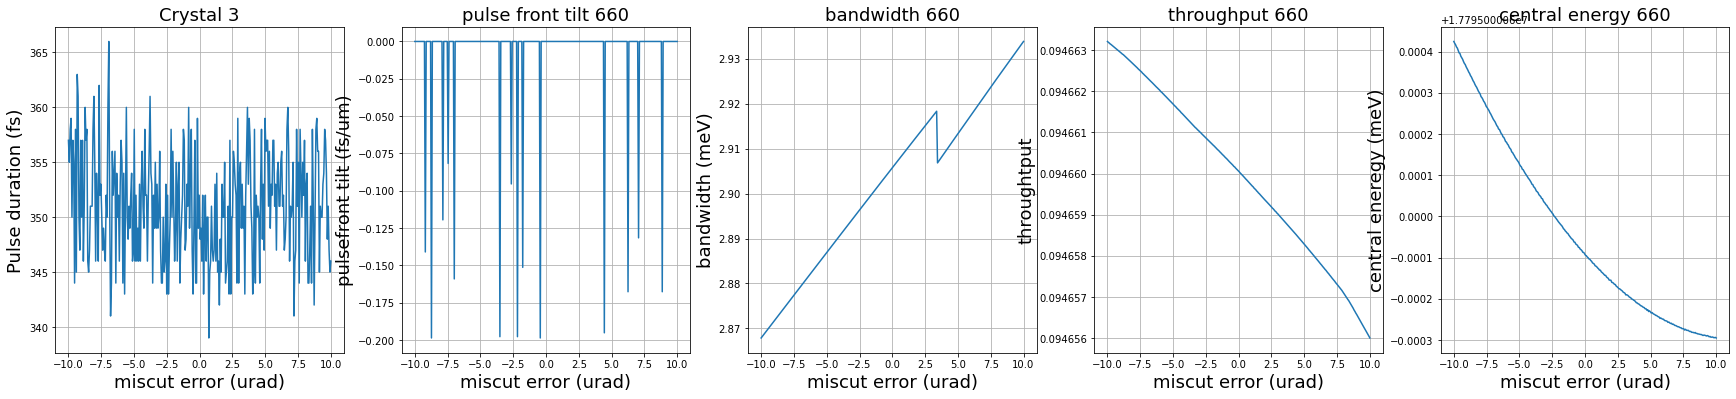

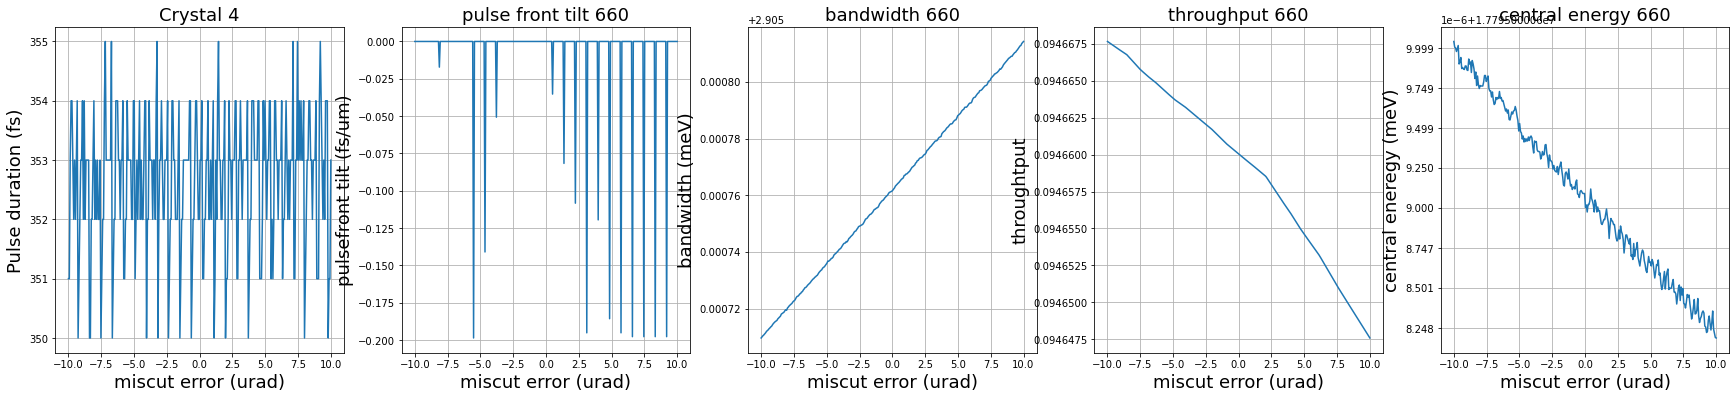

In [7]:
fig_path = "C:/Users/nanw0/GoogleDrive/SLAC/SLAC-Diling/9. 20 Summer/Hasan Mono Analysis/Matt's_Plots/"
hkl = devices[2].hkl
hkl = int(hkl[0]*100+hkl[1]*10+hkl[2])
fname = 'miscut_tolerance_{}_{}keV'.format(
    hkl, round(beam_params['photonEnergy']/1000.,4))

for crystal in [1,2,3,4]:
    with h5py.File(fig_path+fname+'.h5', 'r') as f:
        grpname = 'crystal{}'.format(crystal)
        eta_list = f[grpname+'/miscut_error'][:]
        duration = f[grpname+'/duration'][:]
        tilt = f[grpname+'/tilt'][:]
        bw = f[grpname+'/bandwidth'][:]
        throughput = f[grpname+'/throughput'][:]
        cent_E = f[grpname+'/central_energy'][:]
        
    # plots
    xx = eta_list * 1e6
    xlabel = 'miscut error (urad)'

    # pulse duration
    plt.figure(figsize=(30,6))
    plt.subplot(1,5,1)
    plt.plot(xx, np.abs(duration))
    plt.xlabel(xlabel,fontsize=(18))
    plt.ylabel('Pulse duration (fs)',fontsize=(18))

    plt.grid()
    plt.title('Crystal {}'.format(crystal),fontsize=(18))

    # pulsefront tilt
    plt.subplot(1,5,2)
    plt.plot(xx, tilt)
    plt.xlabel(xlabel,fontsize=(18))
    plt.ylabel('pulsefront tilt (fs/um)',fontsize=(18))

    plt.grid()
    plt.title('pulse front tilt {}'.format(hkl),fontsize=(18))
    # bandwidth
    plt.subplot(1,5,3)
    plt.plot(xx, 1e3*bw)
    plt.xlabel(xlabel,fontsize=(18))
    plt.ylabel('bandwidth (meV)',fontsize=(18))

    plt.grid()
    plt.title('bandwidth {}'.format(hkl),fontsize=(18))

    # throughput
    plt.subplot(1,5,4)
    plt.plot(xx, throughput)
    plt.xlabel(xlabel,fontsize=(18))
    plt.ylabel('throughtput',fontsize=(18))

    plt.grid()
    plt.title('throughput {}'.format(hkl),fontsize=(18))

    # central energy
    plt.subplot(1,5,5)
    plt.plot(xx, 1e3*cent_E)
    plt.xlabel(xlabel,fontsize=(18))
    plt.ylabel('central eneregy (meV)',fontsize=(18))

    plt.grid()
    plt.title('central energy {}'.format(hkl),fontsize=(18))

    plt.savefig(fig_path+'crystal{}_'.format(crystal)+fname+'.png')

In [8]:
print('time per slice {}ms'.format(1000*(tfin-tstart)/4/2/NN/pulse.N))
print('total time {}s'.format(tfin-tstart))

time per slice 172.74876877051614ms
total time 36899.13700938225s


In [9]:
print(fig_path+fname)

C:/Users/nanw0/GoogleDrive/SLAC/SLAC-Diling/9. 20 Summer/Hasan Mono Analysis/Matt's_Plots/miscut_tolerance_660_17.795keV


In [10]:
fig_path

"C:/Users/nanw0/GoogleDrive/SLAC/SLAC-Diling/9. 20 Summer/Hasan Mono Analysis/Matt's_Plots/"